<a href="https://colab.research.google.com/github/prakrutpatel/mask-rcnn/blob/main/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow 2 implementation of Mask RCNN on a custom dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using tensorboard for logging purposes

In [ ]:
%load_ext tensorboard

In [ ]:
import os
import sys
import cv2
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn' #change this based your root directory
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class TortoiseConfig(Config):
    """Configuration for training on the tortoise dataset.
    """
    # Give the configuration a recognizable name
    NAME = "tortoise"

    # Train on 1 GPU and 3 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (tortoise)

    # All of our training images are 224 * 224 but we need an image size that is divisible by 2 atleast 6 times. Therefore we use 256 * 256.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet101'


    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = TortoiseConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Loading mask from specified dataset



In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "tortoise"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

Prepare and load mask from training dataset

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/dataset/train/cocojson.json', '/content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/dataset/train/')
dataset_train.prepare()

Prepare and load mask from validation dataset

In [ ]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/dataset/val/cocojson.json', '/content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/dataset/val/')
dataset_val.prepare()

Display a few images and mask

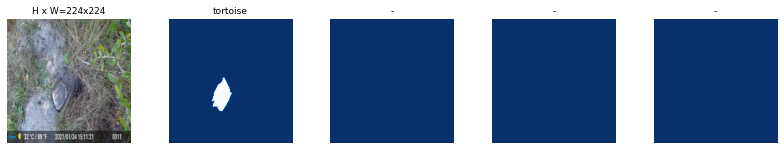

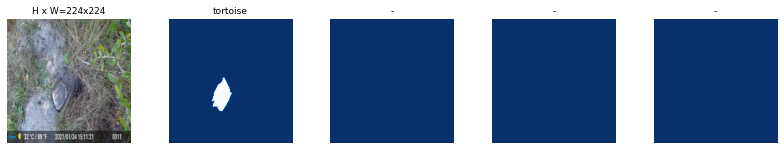

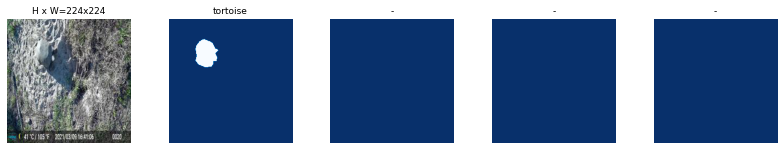

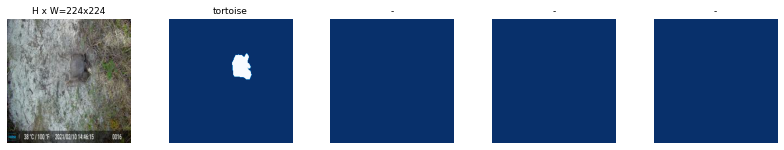

In [ ]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
start_train = time.time()
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=4,
            custom_callbacks=[tensorboard_callback],
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/logs/tortoise20210805T2122/mask_rcnn_tortoise_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (Time

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_cl

500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 3.0000 - loss: 0.6887 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.1966

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


500/500 [==============================] - 234s 388ms/step - batch: 249.5000 - size: 3.0000 - loss: 0.6887 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.1966 - val_loss: 1.1900 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.3530 - val_mrcnn_class_loss: 0.1566 - val_mrcnn_bbox_loss: 0.2837 - val_mrcnn_mask_loss: 0.3868
Epoch 2/4
500/500 [==============================] - 132s 264ms/step - batch: 249.5000 - size: 3.0000 - loss: 0.2017 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1180 - val_loss: 1.0224 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.3752 - val_mrcnn_class_loss: 0.0937 - val_mrcnn_bbox_loss: 0.1651 - val_mrcnn_mask_loss: 0.3796
Epoch 3/4
500/500 [==============================] - 132s 265ms/step - batch: 249.5000 - size: 3.0000 - loss: 0.1232 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0050 - mrcnn_class_loss: 

In [ ]:
# Fine tune all layers.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8,
            custom_callbacks=[tensorboard_callback],
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/logs/tortoise20210805T2122/mask_rcnn_tortoise_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/ro

500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 3.0000 - loss: 0.3234 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0837

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


500/500 [==============================] - 200s 366ms/step - batch: 249.5000 - size: 3.0000 - loss: 0.3234 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0837 - val_loss: 2.8997 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.3556 - val_mrcnn_class_loss: 0.2279 - val_mrcnn_bbox_loss: 0.2307 - val_mrcnn_mask_loss: 0.6254
Epoch 6/8
500/500 [==============================] - 183s 365ms/step - batch: 249.5000 - size: 3.0000 - loss: 0.1889 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0087 - mrcnn_mask_loss: 0.0654 - val_loss: 1.9660 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.2957 - val_mrcnn_class_loss: 0.1418 - val_mrcnn_bbox_loss: 0.1215 - val_mrcnn_mask_loss: 0.4195
Epoch 7/8
500/500 [==============================] - 183s 366ms/step - batch: 249.5000 - size: 3.0000 - loss: 0.1646 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 

In [ ]:
class InferenceConfig(TortoiseConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    DETECTION_MIN_CONFIDENCE = 0.50
    

inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/logs/tortoise20210805T2122/mask_rcnn_tortoise_0008.h5
Re-starting from epoch 8


In [ ]:
def get_segment_crop(img,tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

In [ ]:
import skimage
real_test_dir = '/content/drive/MyDrive/Mask RCNN/tortoise_mask_rcnn/dataset/test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
index = 0
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    crop_img = get_segment_crop([224,224], mask=r['masks'])
    x,y,w,h = r['rois'][0][0],r['rois'][0][1],r['rois'][0][2],r['rois'][0][3]
    #cropped_image = img[x:w, y:h]
    #cv2.imwrite('crop'+str(index)+'.jpg', cropped_image)
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    index +=1
    break

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


ValueError: ignored